proyecto 2 MPV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime, timedelta, date, time
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
#1.0. Carga de archivos y revision preliminar de contenido y formato
data_train = pd.read_parquet('datos/data_train.parquet')
data_test  = pd.read_parquet('datos/data_test.parquet')

In [5]:
#1.1. Se verifican los valores nulos, cantidad y 
def Verificacion01(data):
    features = data.columns
    distincts = []
    distincts_list = []
    for elem in features:
        distincts.append(len(data[elem].unique()))
        distincts_list.append(data[elem].unique())

    cant_faltantes = round(data.isna().sum())
    porcentaje_faltantes = round(data.isna().sum()/len(data)*100,2)
    tipo_dato = data.dtypes
    df = pd.DataFrame({#"features":features ,
                    "distincts":distincts,
                    "distincts_list": distincts_list,
                    "Tipo":tipo_dato,
                    "Faltantes":cant_faltantes ,
                    "Faltantes_%":porcentaje_faltantes})
    return df


In [8]:
Verificacion01(data_train)
#Verificacion01(data_test)

,distincts,distincts_list,Tipo,Faltantes,Faltantes_%
Unnamed: 0,197549,"[861131, 200972, 554622, 540321, 448920, 99139...",int64,0,0.00
id,197549,"[CScTjaFiP6yCzS8tFX0ZVA==, DlCxox9+FuugkxS2kBV...",object,0,0.00
ad_type,1,[Propiedad],object,0,0.00
start_date,145,"[2020-12-14, 2020-09-16, 2020-08-19, 2020-11-2...",object,0,0.00
end_date,446,"[9999-12-31, 2021-05-14, 2020-08-20, 2020-11-3...",object,0,0.00
created_on,145,"[2020-12-14, 2020-09-16, 2020-08-19, 2020-11-2...",object,0,0.00
lat,51078,"[6.203, 4.7227485, 4.709, nan, 5.04900894, 4.7...",float64,49498,25.06
lon,50109,"[-75.572, -74.0731146, -74.03, nan, -75.506801...",float64,49498,25.06
l1,1,[Colombia],object,0,0.00
l2,31,"[Antioquia, Cundinamarca, Santander, Caldas, A...",object,0,0.00


In [9]:
#Se eleminan los Id porque no solo sirven como indicador y necesitamos la data que tiene la informacion

def borradoDatos(data):
    data.drop(columns=['Unnamed: 0', 'id','ad_type','operation_type','geometry','l4', 'l5', 'l6'],inplace=True)
borradoDatos(data_train)
borradoDatos(data_test)


In [10]:
#Se le da formato a las fechas:
# 4 Pasar valores start_date, end_date, created_on a tipo datetime

def Correcion_end_date_faltantes(data):
    from pandas.tseries.offsets import DateOffset
    #Se identifican fechas con fallas
    fechas = data['end_date'].isnull()
    for i in range(len(fechas)):
        if fechas[i]:
            # Para las fechas con fallas se verifica la fecha de incio de publicacion 
            #   y el Periodo del precio "price_period" (Diario, Semanal, Mensual)
            if data['price_period'][i] == "Mensual":
                fechas[i] = data['start_date'][i]+DateOffset(months=1)
            elif data['price_period'][i] == "Semanal":
                fechas[i] = data['start_date'][i]+DateOffset(weeks=1)
            else:
                #En ultima opcion se asume que por lo menos estuvo publicado por 1 dia
                fechas[i] = data['start_date'][i]+DateOffset(days=1)
        else:
            fechas[i] = data['end_date'][i]
    return fechas

def correccion_fechas(data):
    #  Los valores de 'start_date' no tienen problema
    data['start_date'] = data['start_date'].astype('datetime64[D]')

    #  Los valores de 'end_date' presentan problemas que se corrigen
    data['end_date'] = pd.to_datetime(data['end_date'],errors='coerce')
    data['end_date'] = pd.to_datetime(Correcion_end_date_faltantes(data),errors='coerce')

    #  Los valores de 'created_on' no tienen problema
    data['created_on'] = data['created_on'].astype('datetime64[D]')
    data['dias_pub'] = ( data['end_date'] - data['created_on'] ).dt.days+1
    data['dias_pub'] = data['dias_pub'].astype('Int32')
    
    
    # Se verifica que el intervalo tanto para train como para test es el sig:
    # (Timestamp('2020-07-27 00:00:00'), Timestamp('2021-10-19 00:00:00')) 
    #Minimo y maximo de fechas presentes necesario para conseguir tabla US$-COP  
    fecha_min = data[['created_on']].min()
    fecha_max = data[['end_date']].max()
    
    data.drop(columns=['end_date', 'start_date','price_period'],inplace=True)
    return fecha_min , fecha_max

int_fechas_data_train = correccion_fechas(data_train)
int_fechas_data_test = correccion_fechas(data_test)


In [11]:
#Trabajo con valores nulos de latitud y longitud

 # Se utilizan las coordenas conocidas en funcion de l2 y l3  
def nulos_latylon(data):
    #Archivo que contiene coordenadas en funcion de L2 y L3
    # Esta tabla de relaciones se obtiene corriendo el archivo "relacion_Prov_coord.ipynb"
    relacion_Prov_coord = pd.read_csv('datos/relacion_Prov_coord2.csv')

    #Es indiferente si se usa lat o lon las dos son nan simultantenamente
    # esto se puede mejorar con un or entre lat y lon 
    indicador = list(data.lat.fillna('Err'))

    #Todas las filas de la data train tienen el valor l2 (provincia) 
    # pero se chequea por si en futuras entradas no lo tiene
    L2 = list(data.l2.fillna('Err'))
    L3 = list(data.l3.fillna('Err'))
    
    longitud = []
    latitud = []
    #Se revisan valores nulos de las coordenadas
    for i in range(len(indicador)):
        if indicador[i] == 'Err':
            if L3[i] != 'Err':
                try:
                    #Se procede a buscar la coordenada
                    direccion = relacion_Prov_coord.loc[(relacion_Prov_coord['l2'] == L2[i]) & (relacion_Prov_coord['l3'] == L3[i])]
                    longitud.append(direccion.lon.iloc[0])
                    latitud.append(direccion.lat.iloc[0])
                except:
                    try:
                        #En caso de no haber una combibinacion l2- l3 se escoge al azar una ubicacion restringido a l2 
                        localidades_en_provincia = relacion_Prov_coord.loc[(relacion_Prov_coord['l2'] == L2[i])]
                        k = random.randint(0,localidades_en_provincia.shape[0]-1)
                        longitud.append(localidades_en_provincia.lon.iloc[k])
                        latitud.append(localidades_en_provincia.lat.iloc[k])
                    except:
                        longitud.append(i)
                        latitud.append('Err')
            else:
                try:
                    #En caso de no concer l3 se escoge al azar una ubicacion restringido a l2 
                    localidades_en_provincia = relacion_Prov_coord.loc[(relacion_Prov_coord['l2'] == L2[i])]
                    k = random.randint(0,localidades_en_provincia.shape[0]-1)
                    longitud.append(localidades_en_provincia.lon.iloc[k])
                    latitud.append(localidades_en_provincia.lat.iloc[k])
                except:
                    longitud.append(i)
                    latitud.append('Err')
        else:
            longitud.append('x')
            latitud.append('x')
            
    df = pd.DataFrame({"latitud":latitud,"longitud":longitud,"indicador":indicador}) 
    data = data.join(df) 
    for i in range(data.shape[0]):
        if data.indicador[i] == "Err":
            data.lat[i] = data.latitud[i]
            data.lon[i] = data.longitud[i]
    data.drop(columns=['latitud', 'longitud','indicador'],inplace=True)
    return data        

data_train = nulos_latylon(data_train)
data_test = nulos_latylon(data_test)

In [12]:
#Nos quedamos solo con las coordenadas Lat y lon ya depuradas
def borradoDatos2(data):
    data.drop(columns=['l1', 'l2', 'l3'],inplace=True)
    
borradoDatos2(data_train)
borradoDatos2(data_test)

#Se limitan las coordenas a Colombia (Forma muy basica) -Manejo outlaiers
# Solo para data_train porque implica eliminar filas 
def limites(Data_util):
    Data_util = Data_util.loc[Data_util["lat"] <   14]   #Limite Norte
    Data_util = Data_util.loc[Data_util["lat"] >  -5 ]   #Limite Sur
    Data_util = Data_util.loc[Data_util["lon"] <  -65]   #Limite Este
    Data_util = Data_util.loc[Data_util["lon"] > -83 ]   #Limite Oeste
    return Data_util

data_train = limites(data_train)

In [16]:
#Trabajo conjunto con columnas Price y currency

# Se obtiene una tabla pasar los valores de US$ a pesos colombianos en la fecha correspondiente
# Obtenido de https://www.investing.com/currencies/usd-cop-historical-data
def df_USD_COP():
    USD_COP  = pd.read_csv('datos/USD_COP Historical Data.csv',decimal=",")
    USD_COP['Date'] = USD_COP['Date'].astype('datetime64[D]')
    USD_COP['Price'] = USD_COP['Price'].apply(lambda x: x.replace(',',''))
    USD_COP['Price'] = USD_COP['Price'].astype('float64')
    USD_COP.drop(columns=['Open', 'High','Low','Vol.','Change %'],inplace=True)
    return USD_COP

USD_COP = df_USD_COP()
#Convertir de USD a COP
def buscar_precio(fecha,USD_COP):
    salida = 0
    promedio = USD_COP.loc[:,"Price"].mean()
    #Verficamos si la fecha esta en la tabla
    for i in range(USD_COP.shape[0]):
        if USD_COP.loc[i,"Date"] == fecha:
            salida = USD_COP.loc[i,"Price"]
            break
    #Si no se encontro la fecha usa el promedio del precio
    if salida == 0:
        salida = promedio
    return salida

def conver_USD_COP(data,USD_COP):
    data['price'] = data.apply(lambda x: x['price']  if x['currency'] == 'COP'  else x['price']*buscar_precio(x['created_on'],USD_COP) ,axis=1)


USD_COP = df_USD_COP()
conver_USD_COP(data_train,USD_COP)

#Se pueden borrar pero tambien se pueden usar como variables discretas
#data_train.drop(columns=['currency'],inplace=True)
#data_test.drop(columns=['currency'],inplace=True)

#Para data_train se eliminan los valores nan de la columnas price ya que son pocos
data_train = data_train.dropna(subset=['price','currency'])

#Para data_test
data_test["currency"] = data_test["currency"].fillna("COP")


In [61]:
#Manejo de caracteristicas del inmueble

def espacios(data):
    data['rooms'] = data['rooms'].astype('Int32')        #.astype('Int64')
    data['bedrooms'] = data['bedrooms'].astype('Int32')
    data['bathrooms'] = data['bathrooms'].astype('Int32')
    #En primera aproximacion se elimina pero con la info en "description se puede llenar esta"
    data.drop(columns=['surface_total', 'surface_covered'],inplace=True)
espacios(data_train)
espacios(data_test)


In [18]:
#En primera aproximacion se elimina "description" pero el objetivo siguiente debe ser sacar la mayor info de aqui
data_train.drop(columns=['description','title'],inplace=True)
data_test.drop(columns=['description','title'],inplace=True)

In [19]:
#Hasta aqui podriamos asumir que es el trabajo de Data Engineering
#punto de control  1/2
#data_train.to_csv('data_train01.csv',index=False)
#data_test.to_csv('data_test01.csv',index=False)
data_train.to_parquet("data_train01.parquet")
data_test.to_parquet("data_test01.parquet")

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
#A partir de aqui empieza el proceso de Data Science
#punto de control  2/2
#Vers 11 esta norma precio 
data_train = pd.read_parquet('data_train01.parquet')
data_test  = pd.read_parquet('data_test01.parquet')

#No se por que se pierden los formatos de fechas
data_train['created_on'] = data_train['created_on'].astype('datetime64[D]')
data_test['created_on'] = data_test['created_on'].astype('datetime64[D]')

#cuando se cargan nuevamente hay volverlos int
def espacios(data):
    data['rooms'] = data['rooms'].astype('Int32')        #.astype('Int64')
    data['bedrooms'] = data['bedrooms'].astype('Int32')
    data['bathrooms'] = data['bathrooms'].astype('Int32')
    data['dias_pub'] = data['dias_pub'].astype('Int32')
espacios(data_train)
espacios(data_test)

In [3]:
#1.1. Se verifican los valores nulos, cantidad y 
def Verificacion01(data):
    features = data.columns
    distincts = []
    distincts_list = []
    for elem in features:
        distincts.append(len(data[elem].unique()))
        distincts_list.append(data[elem].unique())

    cant_faltantes = round(data.isna().sum())
    porcentaje_faltantes = round(data.isna().sum()/len(data)*100,2)
    tipo_dato = data.dtypes
    df = pd.DataFrame({#"features":features ,
                    "distincts":distincts,
                    "distincts_list": distincts_list,
                    "Tipo":tipo_dato,
                    "Faltantes":cant_faltantes ,
                    "Faltantes_%":porcentaje_faltantes})
    return df

In [4]:
Verificacion01(data_train)

,distincts,distincts_list,Tipo,Faltantes,Faltantes_%
created_on,145,"[2020-12-14T00:00:00.000000000, 2020-09-16T00:...",datetime64[ns],0,0.00
lat,51223,"[6.203, 4.7227485, 4.709, 7.1172633, 6.2443382...",float64,0,0.00
lon,50255,"[-75.572, -74.0731146, -74.03, -73.1156668, -7...",float64,0,0.00
rooms,30,"[<NA>, 5, 3, 1, 4, 2, 7, 6, 9, 8, 15, 22, 14, ...",Int32,169984,86.08
bedrooms,38,"[4, 3, <NA>, 5, 1, 2, 7, 6, 0, 8, 9, 15, 10, 2...",Int32,157006,79.50
bathrooms,21,"[4, 2, 1, 8, 3, 5, <NA>, 6, 10, 7, 9, 12, 20, ...",Int32,41065,20.79
price,6096,"[9000000000.0, 625000000.0, 420000000.0, 13100...",float64,0,0.00
currency,2,"[COP, USD]",object,0,0.00
property_type,8,"[Casa, Apartamento, Otro, Oficina, Finca, Lote...",object,0,0.00
dias_pub,429,"[2, 241, 8, 78, 12, 92, 1, 46, 21, 39, 50, 114...",Int32,0,0.00


In [5]:
#Codificamos el tipo de moneda
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()

def cod_currency(data):
    data['currency'] = label_encoder.fit_transform(data['currency'])

cod_currency(data_train)
cod_currency(data_test)

In [6]:
#Codificamos los tipos de propiedad

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown = 'ignore')

def cod_property_type(data):
    featureArray = ohe.fit_transform(data[['property_type']]).toarray()
    #featureLabels = ohe.categories_
    featureLabels = data["property_type"].unique()
    features = pd.DataFrame(featureArray,columns = featureLabels)
    new_data = pd.concat([data,features],axis=1)
    for elem in featureLabels:
        new_data[elem] = new_data[elem].astype('Int32')
    new_data.drop(columns=['property_type'],inplace=True)
    return new_data 


data_train.reset_index(inplace=True)
data_test.reset_index(inplace=True)

data_train.drop(columns=['index'],inplace=True)
data_test.drop(columns=['index'],inplace=True)

data_train = cod_property_type(data_train)
data_test = cod_property_type(data_test)


In [7]:
#Normalizamos las lat, long 
def norm_val_float(data):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(data[['lat']])
    data['lat'] = scaler.transform(data[['lat']])
    scaler.fit(data[['lon']])
    data['lon'] = scaler.transform(data[['lon']])

norm_val_float(data_train)
    

In [8]:
#En este momento se puede hacer una mejora con respecto a los faltantes de rooms,...
def MejoraCaractInmueble(data,sin_bed,sin_room):
    for elem in sin_bed:
        data['bedrooms'] = data.apply(lambda x: 0  if x[elem] == 1  else x['bedrooms'] ,axis=1)
    for elem in sin_room:
        data['rooms'] = data.apply(lambda x: 0  if x[elem] == 1  else x['rooms'] ,axis=1)    
        data['bathrooms'] = data.apply(lambda x: 0  if x[elem] == 1  else x['bathrooms'] ,axis=1)  
        
        
lista_sin_bed = ['Otro', 'Oficina', 'Finca', 'Lote', 'Local comercial', 'Parqueadero' ]
lista_sin_room = ['Otro', 'Finca', 'Lote', 'Parqueadero']
MejoraCaractInmueble(data_train,lista_sin_bed,lista_sin_room)
MejoraCaractInmueble(data_test,lista_sin_bed,lista_sin_room)

In [10]:
#SE rellenan los faltantes de la descripcion del inmueble 

#Se borrara la fecha ya que la imputacion no trabaja con datos tipo fecha
data_train.drop(columns=['created_on'],inplace=True)
data_test.drop(columns=['created_on'],inplace=True)

#Se confirma
def espacios(data):
    data['rooms'] = data['rooms'].astype('Int32')        #.astype('Int64')
    data['bedrooms'] = data['bedrooms'].astype('Int32')
    data['bathrooms'] = data['bathrooms'].astype('Int32')
espacios(data_train)
espacios(data_test)

def imputacion_faltantes(data):
    import sklearn
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    iteraciones = 10
    Max_caracteristicas = 5
    lr = LinearRegression()
    imp = IterativeImputer(estimator=lr,
                        sample_posterior=False,
                        max_iter=iteraciones,
                        n_nearest_features=Max_caracteristicas,
                        imputation_order='ascending',
                        skip_complete=False)
    columnas = data.columns
    arreglo = imp.fit_transform(data)
    return pd.DataFrame(arreglo,columns = columnas)

data_train = imputacion_faltantes(data_train)
data_test = imputacion_faltantes(data_test)

c:\Users\JHONATHAN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\impute\_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [11]:
#Se verifica
#Verificacion01(data_train)
Verificacion01(data_test)

,distincts,distincts_list,Tipo,Faltantes,Faltantes_%
lat,24931,"[4.722, 6.1701348, 6.25925267, 6.203, 6.244338...",float64,0,0.0
lon,24343,"[-74.075, -75.587415, -75.6283806, -75.556, -7...",float64,0,0.0
rooms,5831,"[3.0, 3.301191474888877, 1.6748644259958867, 2...",float64,0,0.0
bedrooms,468,"[3.0, 3.280208836045563, 2.3900775489869317, 0...",float64,0,0.0
bathrooms,11146,"[3.0, 1.0, 2.9776133348361857, 2.0, 2.78750116...",float64,0,0.0
currency,2,"[0.0, 1.0]",float64,0,0.0
dias_pub,413,"[9.0, 1.0, 3.0, 2.0, 21.0, 38.0, 43.0, 294.0, ...",float64,0,0.0
Casa,2,"[0.0, 1.0]",float64,0,0.0
Apartamento,2,"[1.0, 0.0]",float64,0,0.0
Lote,2,"[0.0, 1.0]",float64,0,0.0


In [15]:
#2.1 Se discretizara la varible 'price' en dos categorias Alto (1) y Bajo (0)
promedio = data_train["price"].mean()
data_train["target"] = (data_train['price'] >= promedio).astype(int) 
print("promedio = ",round(promedio,2))
print(data_train.target.value_counts())
data_train.drop(columns=['price'],inplace=True)

promedio =  645195032.65
0    151237
1     46243
Name: target, dtype: int64


Precision score: 0.69
Recall score: 0.81
accuracy score: 0.81


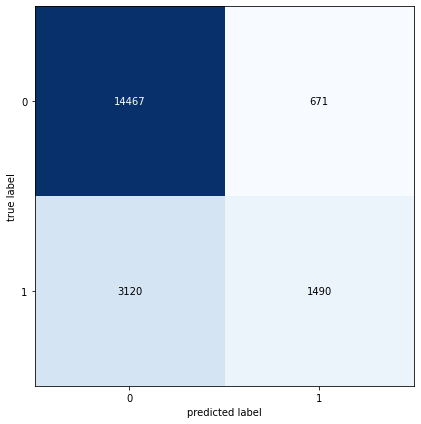

In [16]:
#Modelo de regresion logistica

def regresion_logistica(data_train,iteraciones = 1000):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LogisticRegression
    from mlxtend.plotting import plot_confusion_matrix
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import recall_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import accuracy_score

    X = data_train.drop(["target"],axis = 1)
    y = data_train.target
    ## Dividimos entrenamiento y prueba se deja un 10% ya que la prueba fuerte es con los datos de prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    #configuración del clasificador
    modelo_regresion = LogisticRegression(max_iter=iteraciones)
    #Entrenamiento
    modelo_regresion.fit(X_train, y_train)
    
    #Predicción
    ypred = modelo_regresion.predict(X_test)
    matriz = confusion_matrix(y_test,ypred)
    plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
    plt.tight_layout()
    precision = precision_score(y_test,ypred)
    print('Precision score: {0:0.2f}'.format(precision))
    recall = recall_score(y_test,ypred,average='weighted')
    print('Recall score: {0:0.2f}'.format(recall))
    accuracy = accuracy_score(y_test,ypred)
    print('accuracy score: {0:0.2f}'.format(recall))
    return modelo_regresion
    
modelo = regresion_logistica(data_train)


In [17]:
Verificacion01(data_test)

,distincts,distincts_list,Tipo,Faltantes,Faltantes_%
lat,24931,"[4.722, 6.1701348, 6.25925267, 6.203, 6.244338...",float64,0,0.0
lon,24343,"[-74.075, -75.587415, -75.6283806, -75.556, -7...",float64,0,0.0
rooms,5831,"[3.0, 3.301191474888877, 1.6748644259958867, 2...",float64,0,0.0
bedrooms,468,"[3.0, 3.280208836045563, 2.3900775489869317, 0...",float64,0,0.0
bathrooms,11146,"[3.0, 1.0, 2.9776133348361857, 2.0, 2.78750116...",float64,0,0.0
currency,2,"[0.0, 1.0]",float64,0,0.0
dias_pub,413,"[9.0, 1.0, 3.0, 2.0, 21.0, 38.0, 43.0, 294.0, ...",float64,0,0.0
Casa,2,"[0.0, 1.0]",float64,0,0.0
Apartamento,2,"[1.0, 0.0]",float64,0,0.0
Lote,2,"[0.0, 1.0]",float64,0,0.0


In [20]:

#Predicción
def prediccion(modelo_regresion,X_test):
    ypred = modelo_regresion.predict(X_test)
    return ypred

resultado = prediccion(modelo,data_test)
#predicion = pd.DataFrame(resultado ,columns = "pred")

predicion = pd.DataFrame(list(resultado),columns=["pred"] )
#para la entrega solo valores 0 y 1 en una columna que se llame "pred" y el archivo es tu "nombre de github" + ".csv"

predicion.to_csv('JCSR2022.csv',index=False)
np.unique(resultado, return_counts=True)

c:\Users\JHONATHAN\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


(array([0, 1]), array([65818,    32], dtype=int64))